In [25]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [27]:
file_path = '/content/drive/My Drive/Online Retail.xlsx'
df = pd.read_excel(file_path)
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [28]:
# Drop rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Remove canceled orders (InvoiceNo starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Ensure Quantity and UnitPrice are positive
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Create TotalPrice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


/tmp/ipython-input-4074719972.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [32]:
# Choose a reference date (max date + 1 day)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID and calculate Recency, Frequency, and Monetary
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
}, inplace=True)

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40


In [33]:
# Create RFM scores using quantiles
rfm['R'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine scores into a single RFM segment
rfm['RFM_Segment'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

# RFM Score as a sum
rfm['RFM_Score'] = rfm[['R', 'F', 'M']].sum(axis=1).astype(int)
rfm.head()


,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,4,114,6
12347.0,2,7,4310.00,4,4,4,444,12
12348.0,75,4,1797.24,2,3,4,234,9
12349.0,19,1,1757.55,3,1,4,314,8
12350.0,310,1,334.40,1,1,2,112,4


In [34]:
# Define segments based on RFM Score
def segment(score):
    if score >= 9:
        return 'Champions'
    elif score >= 8:
        return 'Loyal Customers'
    elif score >= 6:
        return 'Potential Loyalist'
    elif score >= 4:
        return 'Needs Attention'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment)
rfm[['RFM_Score', 'Segment']].head()


,RFM_Score,Segment
CustomerID,,
12346.0,6,Potential Loyalist
12347.0,12,Champions
12348.0,9,Champions
12349.0,8,Loyal Customers
12350.0,4,Needs Attention


/tmp/ipython-input-1266943185.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')


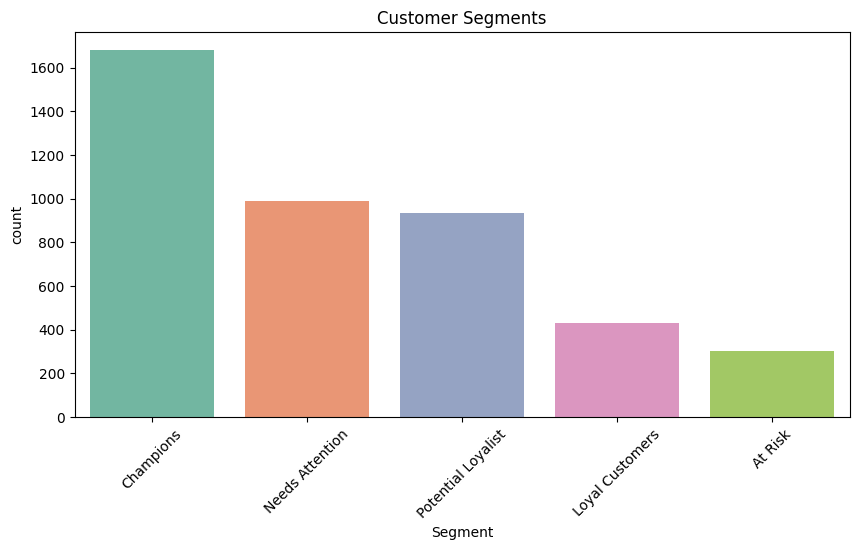

In [35]:
# Plot count of each segment
plt.figure(figsize=(10,5))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index, palette='Set2')
plt.title('Customer Segments')
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-2997015202.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  rfm_heatmap = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')


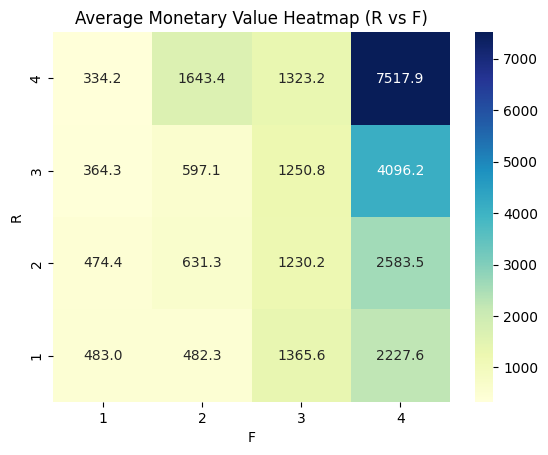

In [36]:
# Heatmap of RFM segments
rfm_heatmap = rfm.pivot_table(index='R', columns='F', values='Monetary', aggfunc='mean')
sns.heatmap(rfm_heatmap, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average Monetary Value Heatmap (R vs F)")
plt.show()
